# Connect4 DQN model
By LaughingSkull 
as new RL agent for my game COnnect-4: https://www.laughingskull.org/Games/Connect4/Connect4.php

## Import dependecies and recheck installation

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

print("All dependencies imported successfully.")
print("torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available. Using CPU.")


All dependencies imported successfully.
torch version: 2.5.1
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU


In [18]:
class Connect4Env:
    ROWS = 6
    COLS = 7

    def __init__(self):
        self.reset()

    def reset(self):
        self.board = np.zeros((self.ROWS, self.COLS), dtype=int)
        self.current_player = 1
        self.done = False
        return self.get_state()

    def get_state(self):
        return self.board.copy()

    def available_actions(self):
        return [c for c in range(self.COLS) if self.board[0][c] == 0]

    def step(self, action):
        if self.done or self.board[0][action] != 0:
            return self.get_state(), -10, True  # Illegal move penalty

        # Drop piece in the selected column
        for row in reversed(range(self.ROWS)):
            if self.board[row][action] == 0:
                self.board[row][action] = self.current_player
                break

        reward = 0
        self.done, winner = self.check_game_over()
        if self.done:
            if winner == self.current_player:
                reward = 1  # Win
            elif winner == 0:
                reward = 0.5  # Draw
            else:
                reward = -1  # Loss

        self.current_player *= -1  # Switch turns
        return self.get_state(), reward, self.done

    def check_game_over(self):
        # Horizontal
        for r in range(self.ROWS):
            for c in range(self.COLS - 3):
                line = self.board[r, c:c+4]
                if abs(np.sum(line)) == 4:
                    return True, int(np.sign(np.sum(line)))

        # Vertical
        for r in range(self.ROWS - 3):
            for c in range(self.COLS):
                line = self.board[r:r+4, c]
                if abs(np.sum(line)) == 4:
                    return True, int(np.sign(np.sum(line)))

        # Diagonal /
        for r in range(3, self.ROWS):
            for c in range(self.COLS - 3):
                line = [self.board[r-i][c+i] for i in range(4)]
                if abs(np.sum(line)) == 4:
                    return True, int(np.sign(np.sum(line)))

        # Diagonal \
        for r in range(self.ROWS - 3):
            for c in range(self.COLS - 3):
                line = [self.board[r+i][c+i] for i in range(4)]
                if abs(np.sum(line)) == 4:
                    return True, int(np.sign(np.sum(line)))

        # Draw
        if not np.any(self.board == 0):
            return True, 0


        return False, None


 ## Neural Network for Q-Learning

In [4]:
class DQN(nn.Module):
    def __init__(self, input_size=6*7, output_size=7):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        return self.fc(x)

## Replay Memory

In [5]:
class ReplayMemory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN Agent

In [19]:
class DQNAgent:
    def __init__(self, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, device=None):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = DQN().to(self.device)
        self.target_model = DQN().to(self.device)
        self.update_target_model()

        self.memory = ReplayMemory()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, state, valid_actions):
        if random.random() < self.epsilon:
            return random.choice(valid_actions)

        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state_tensor).detach().cpu().numpy()[0]  # move to CPU for numpy ops

        # Mask invalid actions
        masked_q = np.full_like(q_values, -np.inf)
        for a in valid_actions:
            masked_q[a] = q_values[a]

        return int(np.argmax(masked_q))

    def remember(self, s, a, r, s2, done):
        self.memory.push(s, a, r, s2, done)

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        batch = self.memory.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, device=self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.bool, device=self.device)

        q_values = self.model(states)
        next_q_values = self.target_model(next_states).detach()
        max_next_q = torch.max(next_q_values, dim=1)[0]

        q_targets = q_values.clone()
        for i in range(len(batch)):
            q_targets[i][actions[i]] = rewards[i] + (0 if dones[i] else self.gamma * max_next_q[i])

        loss = self.loss_fn(q_values, q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


## N-step lookahead, ported from JS

In [23]:
def get_legal_moves(board):
    return [c for c in range(7) if board[0][c] == 0]

def drop_piece(board, col, player):
    new_board = board.copy()
    for row in reversed(range(6)):
        if new_board[row][col] == 0:
            new_board[row][col] = player
            break
    return new_board

def board_to_patterns(board, players):
    patterns = []
    # Horizontal
    for r in range(6):
        for c in range(4):
            window = board[r, c:c+4]
            if any(val in players for val in window):
                patterns.append(window)
    # Vertical
    for r in range(3):
        for c in range(7):
            window = board[r:r+4, c]
            if any(val in players for val in window):
                patterns.append(window)
    # Diagonal \
    for r in range(3):
        for c in range(4):
            window = np.array([board[r+i][c+i] for i in range(4)])
            if any(val in players for val in window):
                patterns.append(window)
    # Diagonal /
    for r in range(3):
        for c in range(3, 7):
            window = np.array([board[r+i][c-i] for i in range(4)])
            if any(val in players for val in window):
                patterns.append(window)
    return patterns

def count_windows_in_pattern(patterns, count, player):
    return sum(1 for w in patterns if np.count_nonzero(w == player) == count and np.count_nonzero(w == 0) == 4 - count)

def get_heuristic(board, player):
    opponent = -player
    patterns = board_to_patterns(board, [player, opponent])
    score = 0
    weights = {2: 10, 3: 100, 4: 1000}
    for n in [2, 3, 4]:
        my_count = count_windows_in_pattern(patterns, n, player)
        opp_count = count_windows_in_pattern(patterns, n, opponent)
        score += weights[n] * (my_count - 1.5 * opp_count)
    return score

def is_terminal_node(board):
    patterns = board_to_patterns(board, [1, -1])
    return count_windows_in_pattern(patterns, 4, 1) > 0 or count_windows_in_pattern(patterns, 4, -1) > 0 or np.all(board != 0)

def minimax(board, depth, maximizing, player, alpha, beta):
    if depth == 0 or is_terminal_node(board):
        return get_heuristic(board, player)

    valid_moves = get_legal_moves(board)
    if maximizing:
        value = -np.inf
        for col in valid_moves:
            child = drop_piece(board, col, player)
            value = max(value, minimax(child, depth - 1, False, player, alpha, beta))
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return value
    else:
        value = np.inf
        opponent = -player
        for col in valid_moves:
            child = drop_piece(board, col, opponent)
            value = min(value, minimax(child, depth - 1, True, player, alpha, beta))
            beta = min(beta, value)
            if beta <= alpha:
                break
        return value

def n_step_lookahead(board, player, depth=3):
    valid_moves = get_legal_moves(board)
    scores = {}
    for move in valid_moves:
        new_board = drop_piece(board, move, player)
        score = minimax(new_board, depth - 1, False, player, -np.inf, np.inf)
        scores[move] = score

    max_score = max(scores.values())
    best_moves = [m for m, s in scores.items() if s == max_score]
    center = 3
    best_moves.sort(key=lambda x: abs(center - x))  # prefer center columns
    return best_moves[0]


## Training loop - DQN against lookahead opponent (Prophet-style)

In [27]:
SEED = 666
random.seed(SEED)
np.random.seed(SEED)

# Create environment and agent
env = Connect4Env()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)
agent = DQNAgent(device=device)

lookahead_depth = 5  # prophet = 7

# Training settings
num_episodes = 250 # 500+
batch_size = 64
target_update_interval = 10
reward_history = []

start_time = time.time()

with tqdm(total=num_episodes, desc="Training Episodes") as pbar:
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            valid_actions = env.available_actions()
            action = agent.act(state, valid_actions)
            next_state, reward, done = env.step(action)

            # Opponent: N-step lookahead 
            if not done:
                # opp_action = n_step_lookahead(next_state, player=-1, depth=lookahead_depth)
                opp_action = random.choice(env.available_actions())
                next_state, reward, done = env.step(opp_action)
                if done:
                    reward = -1  # Agent lost

            # Store experience and train
            agent.remember(state, action, reward, next_state, done)
            agent.replay(batch_size)

            state = next_state
            total_reward += reward

        reward_history.append(total_reward)

        # Sync target model periodically
        if episode % target_update_interval == 0:
            agent.update_target_model()

        # Progress log
        if episode % 10 == 0:
            avg_reward = np.mean(reward_history[-25:])
            pbar.set_postfix(avg_reward=f"{avg_reward:.2f}", epsilon=f"{agent.epsilon:.3f}")

        pbar.update(1)

end_time = time.time()
elapsed = end_time - start_time
print(f"\nTraining completed in {elapsed/60:.1f} minutes ({elapsed / num_episodes:.2f} s/episode)")


using device: cuda


Training Episodes: 100%|██████████| 250/250 [03:40<00:00,  1.14it/s, avg_reward=0.20, epsilon=0.100] 


Training completed in 3.7 minutes (0.88 s/episode)


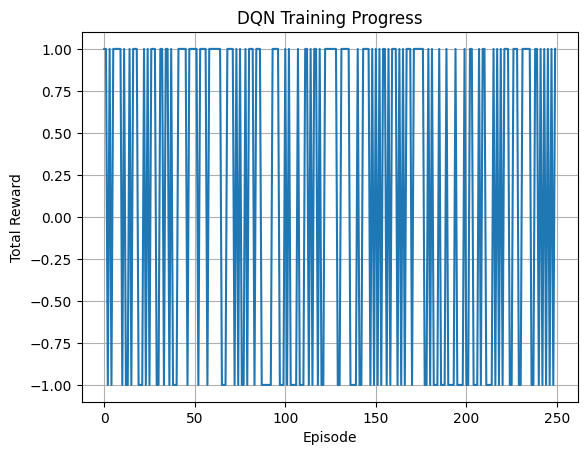

In [28]:
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Progress")
plt.grid(True)
plt.show()

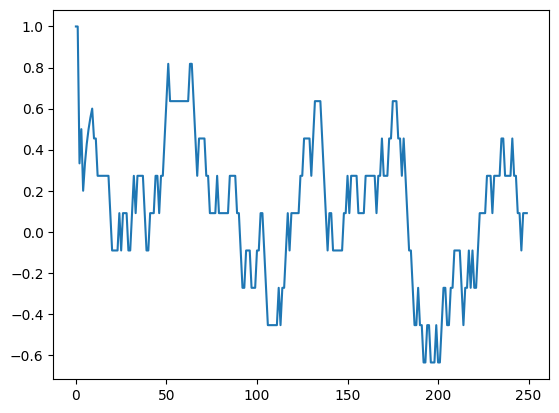

In [29]:
window = 10
smoothed = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]
plt.plot(smoothed)

## save model

In [30]:
# Save the trained model
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_path = f"dqn_model_{timestamp}.pt"

torch.save(agent.model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to dqn_model_20250728-072005.pt
